In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import glob
from datetime import datetime

pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('data/maisons_simples_ML_READY.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46577 entries, 0 to 46576
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   valeur_fonciere            46577 non-null  float64
 1   code_postal                46577 non-null  float64
 2   commune                    46577 non-null  object 
 3   code_departement           46577 non-null  int64  
 4   surface_reelle_bati        46577 non-null  float64
 5   nombre_pieces_principales  46577 non-null  int64  
 6   surface_terrain            46577 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 2.5+ MB


## Gestion des données catégoriques

In [4]:
category_cols = df.select_dtypes(include=['object','category'])
category_cols

,commune
0,SAINT-JULIEN-SUR-REYSSOUZE
1,LANCRANS
2,ABERGEMENT-DE-VAREY (L )
3,SAINTE-JULIE
4,GEX
...,...
46572,PARIS 19
46573,PARIS 19
46574,PARIS 20
46575,PARIS 19


In [5]:
for cat in category_cols.columns:
    cat_val = df[cat].unique()
    print('{} ({}):'.format(cat,len(cat_val)))
    print('{}\n'.format(cat_val))

commune (11947):
['SAINT-JULIEN-SUR-REYSSOUZE' 'LANCRANS' 'ABERGEMENT-DE-VAREY (L )' ...
 'PARIS 18' 'PARIS 19' 'PARIS 20']



In [6]:
df.drop('code_postal', axis=1, inplace=True)
df = pd.get_dummies(df, columns=['code_departement', 'commune'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46577 entries, 0 to 46576
Columns: 12046 entries, valeur_fonciere to commune_ZONZA
dtypes: float64(3), int64(1), uint8(12042)
memory usage: 536.3 MB


In [8]:
#df = pd.get_dummies(df, columns=['nature_mutation'])
#df = pd.get_dummies(df, columns=['b/t/q'])
#df = pd.get_dummies(df, columns=['type_de_voie'])
#df = pd.get_dummies(df, columns=['type_local'])
#df = pd.get_dummies(df, columns=['nature_culture'])
#df = pd.get_dummies(df, columns=['nature_culture_speciale'])

## Start ML

#### Découpage des données pour l'entraînement et l'évaluation de l'apprentissage automatique

In [9]:
from sklearn.model_selection import train_test_split

y = df['valeur_fonciere']
X = df.drop(['valeur_fonciere'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42, shuffle=True)

print(X_train.shape)
print(y_train.shape)

(31206, 12045)
(31206,)


#### Régression linéaire

In [10]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
y_pred = reg.predict(X_test)
reg.score(X_test, y_test)

-5.3965101157781736e+16

#### Cross-validation

In [12]:
from sklearn.model_selection import cross_val_score
cv_reg = LinearRegression()
cv_results = cross_val_score(cv_reg, X, y, cv=5)
print(cv_results)

[-5.59702646e+12 -1.54499064e+16 -1.67563428e+18  1.15487826e-01
 -3.24463425e+17]


In [13]:
np.mean(cv_results)

-4.0311064095977606e+17

#### Régression linéaire avec Lasso

In [14]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.4, normalize=True)
lasso.fit(X_train,y_train)

Lasso(alpha=0.4, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

#### Filtre sur l'importance des features

In [15]:
lasso_df = pd.DataFrame(np.array([lasso.coef_]), columns=X.columns)

for col in lasso_df.columns:
    if lasso_df[col].iloc[0]<1000:
        lasso_df.drop(col, axis=1, inplace=True)

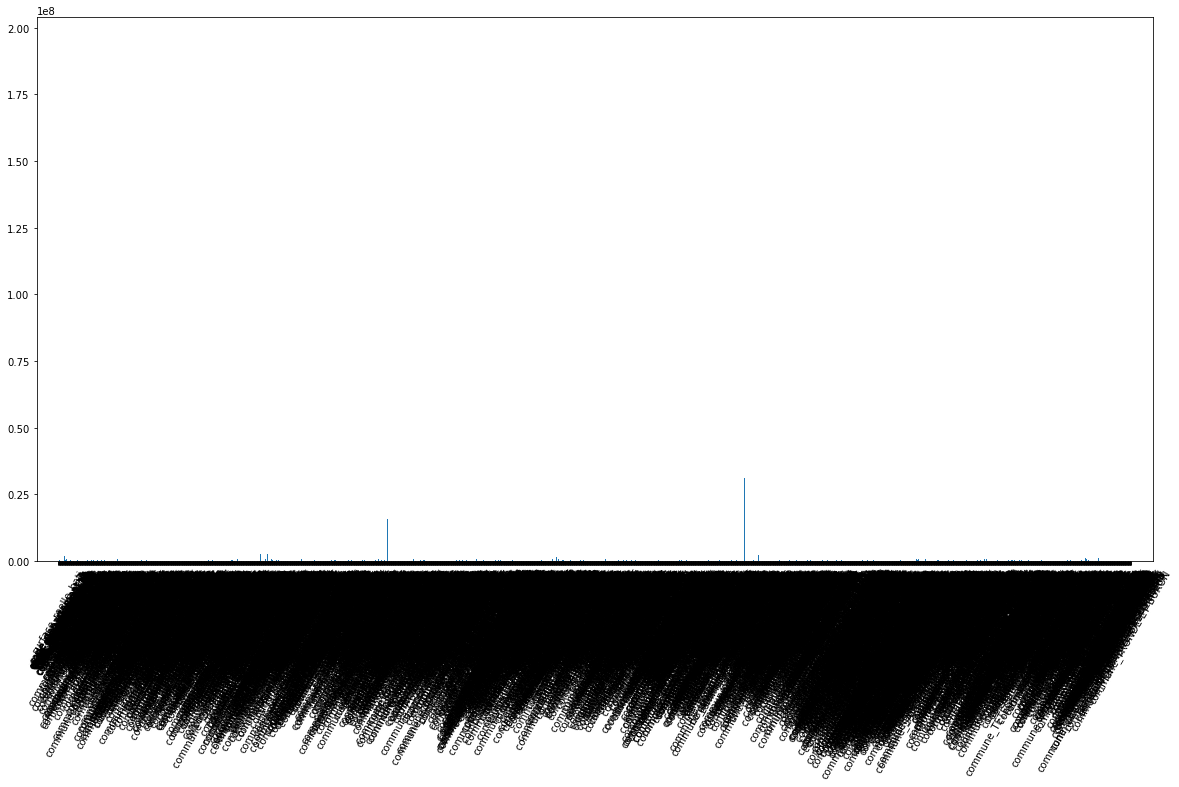

In [16]:
import matplotlib
import matplotlib.pyplot as plt

col_rang = range(len(lasso_df.columns))

plt.figure(figsize=(20,10))
plt.bar(col_rang, lasso_df.iloc[0])
plt.xticks(col_rang, lasso_df.columns, rotation=60)
plt.margins(0.02)
plt.show()